# Flow cytometry analysis, Fig. 1b

In [1]:
options(warn = -1)

# Load required libraries
suppressPackageStartupMessages({
  library(flowCore)       # For reading .fcs files
  library(broom)          # For extracting statistical fits
  library(tidyverse)      # For analysis and plotting
  library(rasilabRtemplates) # Lab ggplot2 theme and color-blind palette
})

# Define data folder and channel names
fcs_file_folder <- c(
  "../../../../data/flow_cytometry/fig1_eyfp_reporter_sgeyfp/day2/", 
  "../../../../data/flow_cytometry/fig1_eyfp_reporter_sgeyfp/day5/", 
  "../../../../data/flow_cytometry/fig1_eyfp_reporter_sgeyfp/day7/"
)

channels <- c(
  "fitc_a" = "yfp", 
  "pe_texas_rd_a" = "rfp",
  "bv421_a" = "bfp"
)

if (!file.exists('../figures')){
    dir.create('../figures')
}


recover called non-interactively; frames dumped, use debugger() to view


## Read in annotations

In [2]:
annotations <- read_csv("../annotations/sampleannotations.csv", show_col_types = F) %>% 
  print()

# A tibble: 3 × 2
   file sgrna
  <dbl> <chr>
1   266 none 
2     5 fluc 
3     6 yfp  


## Read in flow data

In [3]:
flowdata <- list.files(fcs_file_folder, full.names = TRUE, pattern = ".fcs") %>%
  as_tibble_col("file") %>%
  mutate(
    data = map(file, ~ read.FCS(.x, transformation = FALSE, alter.names = TRUE) %>%
      exprs %>%
      as_tibble)
  ) %>%
  unnest(data) %>%
  janitor::clean_names() %>%
  rename_with(~ channels[.x], names(channels)) %>%
  mutate(
    day = str_extract(file, "(?<=day).") %>% as.integer(),
    file = str_extract(file, "(?<=events_)[:graph:]+(?=.fcs$)") %>% as.integer()
  ) %>%
  select(day, file, ssc_a, bfp, yfp, rfp) %>%
  print()

# A tibble: 90,000 × 6
     day  file ssc_a    bfp    yfp    rfp
   <int> <int> <dbl>  <dbl>  <dbl>  <dbl>
 1     2   266  23.3 1562.  -34.7  -40.8 
 2     2   266 225.  2205.   31.2   42.9 
 3     2   266 178.  2962.  -18.9   -9.29
 4     2   266  54.5 3339.   -5.93  36.6 
 5     2   266 180.    83.0 -16.7   24.9 
 6     2   266 161.  1844.   39.3   -5.40
 7     2   266 220.  3010.   10.2   12.5 
 8     2   266 130.   232.   28.7  113.  
 9     2   266 126.  1294.   -1.30 -34.5 
10     2   266 154.  2257.   29.4    8.80
# … with 89,990 more rows


## Join data with annotations

In [4]:
data <- flowdata %>% 
     inner_join(annotations, by = c("file")) %>% 
     print() 

# A tibble: 90,000 × 7
     day  file ssc_a    bfp    yfp    rfp sgrna
   <int> <dbl> <dbl>  <dbl>  <dbl>  <dbl> <chr>
 1     2   266  23.3 1562.  -34.7  -40.8  none 
 2     2   266 225.  2205.   31.2   42.9  none 
 3     2   266 178.  2962.  -18.9   -9.29 none 
 4     2   266  54.5 3339.   -5.93  36.6  none 
 5     2   266 180.    83.0 -16.7   24.9  none 
 6     2   266 161.  1844.   39.3   -5.40 none 
 7     2   266 220.  3010.   10.2   12.5  none 
 8     2   266 130.   232.   28.7  113.   none 
 9     2   266 126.  1294.   -1.30 -34.5  none 
10     2   266 154.  2257.   29.4    8.80 none 
# … with 89,990 more rows


## Plot data

Picking joint bandwidth of 0.0674

Picking joint bandwidth of 0.0674



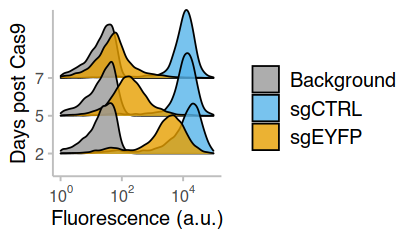

In [5]:
options(repr.plot.width = 3.5, repr.plot.height = 2)

plot_data <- data %>%
  pivot_longer(c("bfp", "yfp", "rfp", "ssc_a"), names_to = "channel") %>%
  filter(channel == "yfp", value >= 1) %>%
  mutate(
    sgrna = recode(sgrna, "none" = "Background", "fluc" = "sgCTRL", "yfp" = "sgEYFP"),
    channel = recode(channel, "yfp" = "EYFP"),
    value = round(value, 2)
  ) %>%
  write_csv("../../../../source_data/figure_1b.csv")

plot_data %>%
  ggplot(aes(x = value, y = as.factor(day), fill = sgrna)) +
  ggridges::geom_density_ridges(alpha = 0.8) +
  scale_x_log10(
    limits = c(1, 1e5),
    breaks = scales::trans_breaks("log10", function(x) 100^x),
    labels = scales::trans_format("log10", scales::math_format(10^.x))
  ) +
  scale_fill_manual(values = cbPalette[c(1, 3, 2)]) +
  labs(x = "Fluorescence (a.u.)", y = "Days post Cas9", fill = "") +
  theme(
    axis.line = element_line(color = "grey"),
    axis.ticks = element_line(color = "grey")
  )

ggsave("../figures/sgyfp_sgfluc_effects_for_validation.pdf", width = 3.5, height = 2)